# Alpha combination - First draft
This Jupyter notebook details a simple first attempt at combining alphas. It is by no means an "optimal" strategy, but is reasonable and can be used as a baseline to compare alternative strategies (i.e. using ML).

Firstly, we import the data from a set of log files. These can be generated by adding the code from the Appendix to the bottom of the initialization function in the main class of a QC algorithm.

We also make dataframes storing the daily percentage change, and the correlations between different stocks for comparison.

Next, we compute the Equal weighted and Markowitz Portfolio theory based returns, determining their sharpe ratios and plotting them. Here we demonstrate some evidence for Markowitz Portfolio Optimization being better than an Equally weighted alternative.

Lastly, we discuss some future additions that could be made to improve the strength and reliability of our findings.

## Importing the data
Commented out is the code to read data from the log text files themselves. This code reads them, combines them and saves them as csvs. It then loads the csvs back in (not commented out) so I only need to send 5 files instead of 50+.

In [653]:
import pandas as pd
import seaborn as sns
import numpy as np
from os import listdir
year_ordered_file_list = []
saving_data_dfs = []
corr_matrices = []
percentage_change_df = []
years = ["2007","2008","2020","2023"]
# filenames = listdir()
# for year in years:
#     year_ordered_file_list.append([filename for filename in filenames if filename[-8:] == year + ".txt"])
#     saving_data_dfs.append(pd.DataFrame())
# year_ordered_file_list[1]
# for i in range(len(years)):
#     for file_name in year_ordered_file_list[i]:
#         file_name_short = file_name[:-4] # removes the .txt, will save the data with this string as the column header
#         f = open(file_name, "r")
#         lines = f.readlines()
        
#         new_col = []
#         for counter, line in enumerate(lines):
#             if "Portfolio value," in line:
#                 after_comma = line.split(sep = ",")[1]
#                 value = after_comma.split(sep="\n")[0] # removes the \n at the end of each line
#                 new_col.append(float(value))
#         saving_data_dfs[i][file_name_short] = new_col

# for i in range(len(years)):
#     saving_data_dfs[i].to_csv("Data" + years[i] + ".csv")

year_ordered_dfs = []
for i in range(len(years)):
    returns_df = pd.read_csv("Data" + years[i] + ".csv")
    returns_df = returns_df.loc[:, ~returns_df.columns.str.contains('^Unnamed')]
    year_ordered_dfs.append(returns_df)

# Make percentage change matrices
for i in range(len(years)):
    percent_change = year_ordered_dfs[i].pct_change()
    percentage_change_df.append(percent_change)

# Make correlation matrices
for i in range(len(years)):
    corr_mat = percentage_change_df[i].corr().dropna(how = "all").dropna(how = "all", axis = 1)
    corr_matrices.append(corr_mat)


Now we look at a heatmap of the correlations

<Axes: >

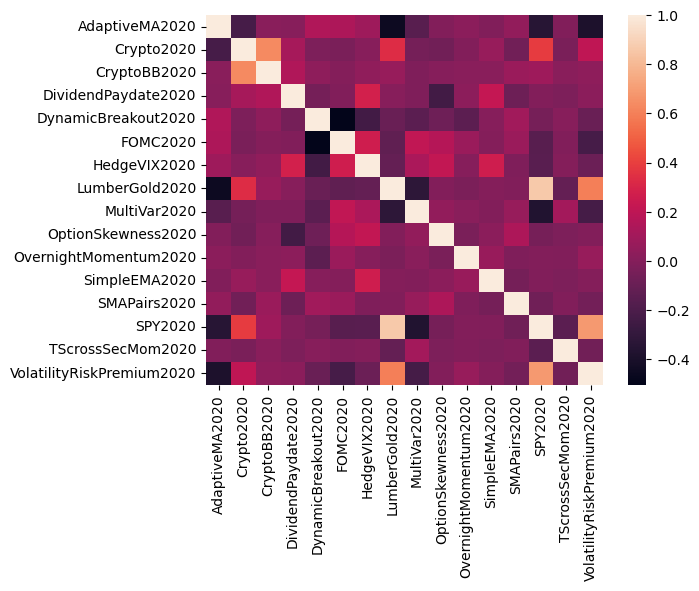

In [654]:
sns.heatmap(corr_matrices[2])

## Including good strategies

I wasn't entirely sure how to decide which strategies to include. Therefore, I opted to keep the top 5 based on my own opinions for the example. In a practical implementation of this a more complex method would be used. Furthermore, this stage introduces some bias as I decided on these 5 strategies knowing they performed well in 2023 (Although: the weighting algorithm doesn't know this, so the bias is hopefully not too impactful). 

Some notes about their performance: I included HedgeVIX mostly as it's the only strategy with a goal of hedging against large market movements, despite it actually losing money over the first covid lockdown. Also although MultiVar is a strategy with low, almost imperceptible returns on this graph, it does in fact make money and furthermore is very stable compared to other strategies and so more leverage can be used on it (We'll see this in the portfolio optimization stage)

<Axes: >

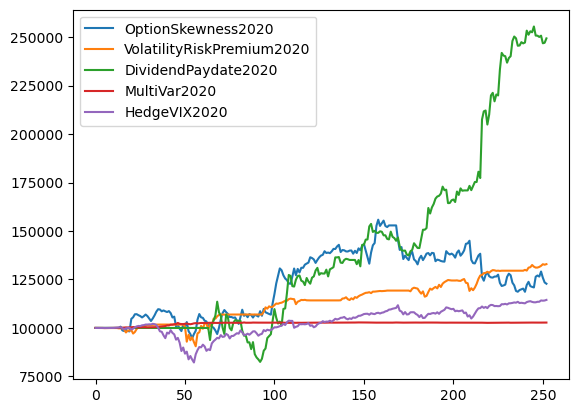

In [655]:
reduced_dfs = []
list_of_strats = ["OptionSkewness", "VolatilityRiskPremium", "DividendPaydate",  "MultiVar", "HedgeVIX"]
for i in range(len(years)):
    list_of_cols = [strat + years[i] for strat in list_of_strats]
    df = year_ordered_dfs[i]
    df = df[list_of_cols]
    reduced_dfs.append(df)

# A plot of the returns of these top 5 strategies:
reduced_dfs[2].plot()

## Distribution of returns
Now we calculate the mean and covariance of these returns. We need these to implement standard markowitz portfolio optimization theory.

In [656]:

# creating percentage change dfs
reduced_percent_change_df =[]

for i in range(len(years)):
    percent_change = reduced_dfs[i].pct_change()
    reduced_percent_change_df.append(percent_change)

# Creating the returns vectors and the covariance matrices
returns_vecs = []
covariance_mats = []
for i in range(len(years)):
    returns_vecs.append(reduced_percent_change_df[i].mean())
    covariance_mats.append(reduced_percent_change_df[i].cov())

covariance_mats[2]

,OptionSkewness2020,VolatilityRiskPremium2020,DividendPaydate2020,MultiVar2020,HedgeVIX2020
OptionSkewness2020,3.854752e-04,-0.000002,-1.240116e-04,6.230158e-07,0.000045
VolatilityRiskPremium2020,-1.862609e-06,0.000114,5.282423e-06,-1.822345e-06,-0.000010
DividendPaydate2020,-1.240116e-04,0.000005,6.663704e-04,-3.322819e-07,0.000078
MultiVar2020,6.230158e-07,-0.000002,-3.322819e-07,5.560323e-07,0.000001
HedgeVIX2020,4.529921e-05,-0.000010,7.760425e-05,1.054780e-06,0.000115


To optimize with Markowitz Portfolio optimization we now need some assumption of the risk free rate. We use the US 10 year treasury rate for each year we consider. More specifically the average of the 10 year treasury rate in July

In [650]:
risk_free = [0.0519, 0.0396, 0.0059, 0.0405] # our risk free rates for each year.
# These strategies only work with 2020, 2023 so we only look at those
years_to_compute = ["2020","2023"]
risk_free = [0.0059, 0.0405]

# Now calculate the risk free rate vector and the inverse of the covariance matrices:

# Difference between mean and RFR vector - note we have to divide by 252, the number of trading days in a year.
rfr_vec = []
for i in range(len(years_to_compute)):
    rfr_vec.append(np.array(returns_vecs[i+2] - risk_free[i]/252))
rfr_vec[1]
# Inverse covariance matrix:
inv_cov = []
for i in range(len(years_to_compute)):
    inv_cov.append(np.linalg.inv(covariance_mats[i+2].to_numpy()))

## Portfolio Optimization

Now we move onto the actual Optimization part of this. There is only a single parameter one should need to modify across the entire notebook, the "goal". Markowitz Optimization works by having some set expected return, and finding the lowest variance portfolio that gets at least that return. This is written in the code such that goal = the multiplicative return we desire over a year. Thus if we wish to see what the weights should be for a portfolio which should (in theory) turn 100000 into 300000 we would set goal = 3. One can find the full derivation of this Markowitz Portfolio optimization in the Cambridge Mathematics Part II - Stochastic Financial Modelling lecture notes. 

In [651]:
# Some parameters to play with
goal = 3.5

# Sets the year we optimize the portfolio with
year_for_opti = 0 # 0 for 2020, 1 for 2023

# Sets the year we calculate the performance over
year_for_calcs = 1 # 0 for 2020, 1 for 2023

# Calculating optimal portfolio based on the historical return distribution:

m = goal-1

# Scaling factor:
scalar = []
for i in range(len(years_to_compute)):
    numerator = (m - (risk_free[i]))/np.sqrt(100000)
    denominator = np.matmul(np.matmul(rfr_vec[i].T, inv_cov[i]), rfr_vec[i])
    scalar.append(numerator/denominator)

# Calculating the weights of our portfolio:
weightings = []
for i in range(len(years_to_compute)):
    weightings.append(scalar[i] * np.matmul(inv_cov[i], rfr_vec[i]))

# We now reformat the weights to make them more presentable
weight_dfs = []
for i in range(len(years_to_compute)):
    weight_df = pd.DataFrame(weightings[i]).T
    weight_df.columns = reduced_percent_change_df[i+2].columns.tolist()
    weight_dfs.append(weight_df)

normalised_weights = []
for i in range(len(years_to_compute)):
    normalised_weights.append(weight_dfs[i]/abs(weight_dfs[i]).sum().sum())

# setting weights to the 2020 weights. For 2023 use weight_dfs[1]
weights = weight_dfs[year_for_opti]
print(weights)

weights = weights.to_numpy()[0]
equal_weights = np.full((1,len(weights)), 1/len(weights)* numerator*775)[0] 
# 775 is arbitrary, but makes it get the same returns as the optimized portfolio
print(equal_weights)

# setting the year we're plotting for:
year = 2 # 2 for 2020, 3 for 2023

# getting the columns of data we need:
list_of_cols = [strat + years[year_for_calcs+2] for strat in list_of_strats]
strategy_values = year_ordered_dfs[year_for_calcs+2][list_of_cols]
weighted_values = strategy_values.copy()
equal_values = strategy_values.copy()
for i,col in enumerate(list_of_cols):
    weighted_values[col] = strategy_values[col] * weights[i]
    equal_values[col] = strategy_values[col] * equal_weights[i]
weighted_values["Optimized"] = weighted_values.sum(axis=1)
weighted_values["Equal"] = equal_values.sum(axis=1)

# Calculating the sharpe ratio:
Portfolio_returns = weighted_values["Optimized"]
Portfolio_pct_change = Portfolio_returns.pct_change()
Portfolio_average_return = Portfolio_pct_change.mean()
Portfolio_std = Portfolio_pct_change.std()
Portfolio_sharpe = (Portfolio_average_return - risk_free[year-2]/252)/Portfolio_std

Equal_returns = weighted_values["Equal"]
Equal_pct_change = Equal_returns.pct_change()
Equal_average_return = Equal_pct_change.mean()
Equal_std = Equal_pct_change.std()
Equal_sharpe = (Equal_average_return - risk_free[year-2]/252)/Equal_std
print("Sharpe = " + str(Portfolio_sharpe))
print("Equal weighted Sharpe = " + str(Equal_sharpe))

   OptionSkewness2020  VolatilityRiskPremium2020  DividendPaydate2020  \
0            0.604397                   1.606247             0.881415   

   MultiVar2020  HedgeVIX2020  
0     24.867569     -0.301807  
[1.2055314 1.2055314 1.2055314 1.2055314 1.2055314]
Sharpe = 0.09098178561679073
Equal weighted Sharpe = 0.11004658118753546


## Weights and Sharpe

When looking at the weights, it's important to note some things:
<ul>
<li> The weights don't need to add to 1, or any particular value. The important thing to note is the relative weights, with MultiVar generally having a much higher weighting because it's a more stable strategy, while other strategies have smaller weights</li>
<li> The Sharpe is independent of the goal</li>
<li> The Sharpe ratio is low, however when adding some context of the equal weighted strategy performance we see the Portfolio Optimizer is performing well, and our strategies just don't have particularly high Sharpe ratios</li>
</ul>
Next, we plot the results

0      602765.697652
1      602765.697652
2      602765.697652
3      602765.697652
4      602765.697652
           ...      
245    688005.306718
246    687222.112568
247    689021.029420
248    690172.145378
249    689389.630907
Name: Equal, Length: 250, dtype: float64

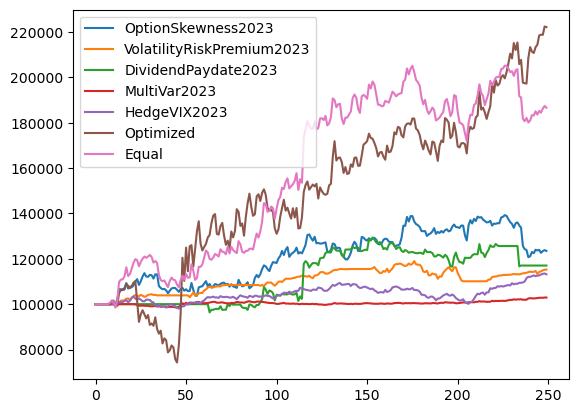

In [652]:
normalised_for_plotting = 100000 * weighted_values/weighted_values.iloc[0]
normalised_for_plotting["Optimized"] = weighted_values["Optimized"] - weighted_values["Optimized"][0] + 100000
normalised_for_plotting["Equal"] = weighted_values["Equal"] - weighted_values["Equal"][0] + 100000


# Plots our portfolio against the individual alphas
normalised_for_plotting.plot()
weighted_values["Equal"]

## Notes

Can see that when the Equal weighted and Optimized portfolio are tuned to get the same returns in 2020, and we test them in 2020, the Optimized one has lower variance and is more consistent, as we would predict. The important hope / goal is that the optimized weights from 2020 generalise to 2023 better than the Equal weights too. By changing the parameters above (set year_for_cals = 1), we can test this. 

Doing so, we see that both portfolios have much higher variance. This is probably due to an increase in the variance of each of the underlying strategies. We also see that the Markowitz Optimised portfolio outperforms the equal weighting one, and is more resistent to the sharp dip in december. This may be an indication that using Markowitz Optimization is better than simply equally weighting the different strategies.

## Discussion

Some notes/improvements:
<ul>
<li> It would be interesting to add backtests of each of the other years in the range, hopefully getting more data to compare equal weighted vs optimized for a wider range of strategies and conditions </li>
<li> Should properly tune the equal weighting weights to accurately match the goal in all cases, at the moment the solution is ad-hoc </li>
<li> Incorporating maximum weights into the program. For instance, we may not be able to use more than 10x leverage for some strategies, and more than 1x for other strategies, so checking this would be wise </li>
<li> Adding proper risk free weights to the graph - At the moment, the strategy borrows at 0% interest, and saves at 0% interest when plotted. One should incorporate proper risk free rates into the plots </li>
<li> Alternative methods for Optimizing the Portfolios </li>
</ul>

# Appendix 1:
Code to copy in to produce the logs. Place at the bottom of the \_\_init\_\_ method.  

In [ ]:
        self.SpySymbol = self.AddEquity("SPY", Resolution.Daily).Symbol
        self.Schedule.On(self.DateRules.EveryDay(self.SpySymbol), self.TimeRules.BeforeMarketClose(self.SpySymbol, 10), self.LogProfit)
        
    def LogProfit(self):
        if not self.IsWarmingUp:
            self.Log(" Portfolio value," + str(self.Portfolio.TotalPortfolioValue))